# LSTM with Tweet Volume

In [7]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from mongo_db import MongoDB

def createTrainingData(dataset: pd.Series):
    training_data_len = math.ceil(len(dataset.values)* 0.8)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset.values.reshape(-1,1))
    train_data = scaled_data[0: training_data_len, :]

    x_train = []
    y_train = []

    for i in range(48, len(train_data)):
        x_train.append(train_data[i-48:i, 0])
        y_train.append(train_data[i, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    return x_train, y_train, training_data_len, scaled_data, scaler

def createTestData(scaled_data: pd.Series, training_data_len, values):
    test_data = scaled_data[training_data_len-48: , : ]
    x_test = []
    y_test = values[training_data_len:]

    for i in range(48, len(test_data)):
        x_test.append(test_data[i-48:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_test, y_test

tweets = pd.read_csv('analzyed.csv', sep=',')
pricedata = pd.read_csv('lrc_snapshot_2_Nov_9_15.csv', sep=',')

Text(0, 0.5, 'Volume')

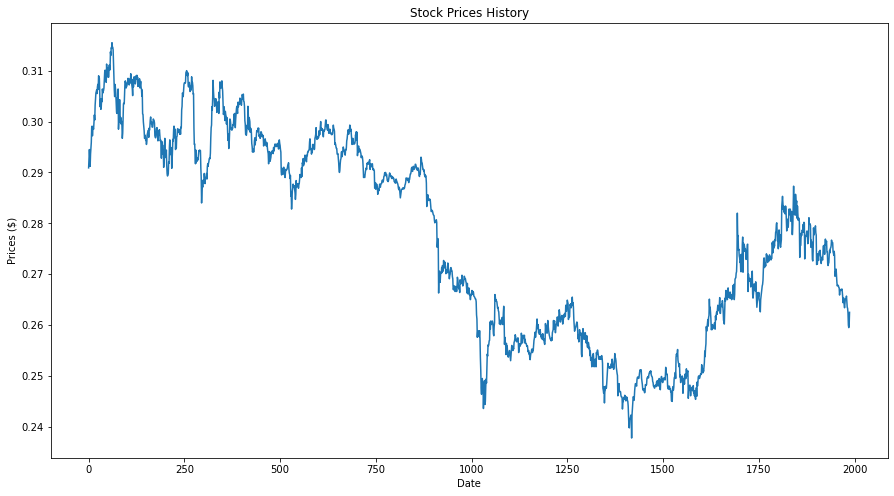

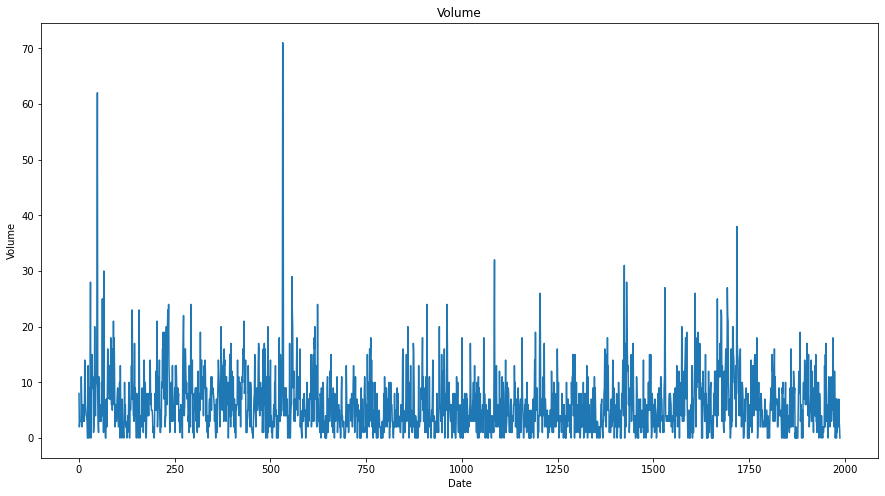

In [8]:
price_data_numeric = pd.to_numeric(pricedata['price'])
volume_numeric = pd.to_numeric(tweets['Volume'])

plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(price_data_numeric)
plt.xlabel('Date')
plt.ylabel('Prices ($)')

plt.figure(figsize=(15, 8))
plt.title('Volume')
plt.plot(volume_numeric)
plt.xlabel('Date')
plt.ylabel('Volume')

In [11]:
x_train_volume, y_train_volume, training_data_len_volume, scaled_data_volume, scaler = createTrainingData(volume_numeric)
x_train_price, y_train_price, training_data_len_price, scaled_data_price, scaler = createTrainingData(price_data_numeric)

x_test_volume, y_test_volume = createTestData(scaled_data_volume, training_data_len_volume, volume_numeric)
x_test_price, y_test_price = createTestData(scaled_data_price, training_data_len_price, price_data_numeric)

input1 = layers.Input(shape=(x_train_price.shape[1], 1))
input2 = layers.Input(shape=(x_train_volume.shape[1], 1))
input = keras.layers.Concatenate()([input1, input2])
lstm_layer1 = layers.LSTM(100, return_sequences=True)(input)
lstm_layer2 = layers.LSTM(100, return_sequences=False)(lstm_layer1)
dense_layer_1 = layers.Dense(25)(lstm_layer2)
output = layers.Dense(1)(dense_layer_1)
model = keras.models.Model(inputs=[input1, input2], outputs=output)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 48, 1)]      0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 48, 1)]      0           []                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 48, 2)        0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  (None, 48, 100)      41200       ['concatenate_3[0][0]']    

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit([x_train_price, x_train_volume], y_train_price, batch_size = 1, epochs=5)

Epoch 1/5
1543/1543 [==============================] - 15s 9ms/step - loss: 0.0024
Epoch 2/5
1543/1543 [==============================] - 14s 9ms/step - loss: 8.7634e-04
Epoch 3/5
1543/1543 [==============================] - 14s 9ms/step - loss: 7.8732e-04
Epoch 4/5
1543/1543 [==============================] - 14s 9ms/step - loss: 7.1989e-04
Epoch 5/5
1543/1543 [==============================] - 14s 9ms/step - loss: 5.6989e-04


In [13]:
predictions = model.predict((x_test_price, x_test_volume))
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions[0] - y_test_price)**2)
rmse

13/13 [==============================] - 0s 9ms/step


0.021607256371668663

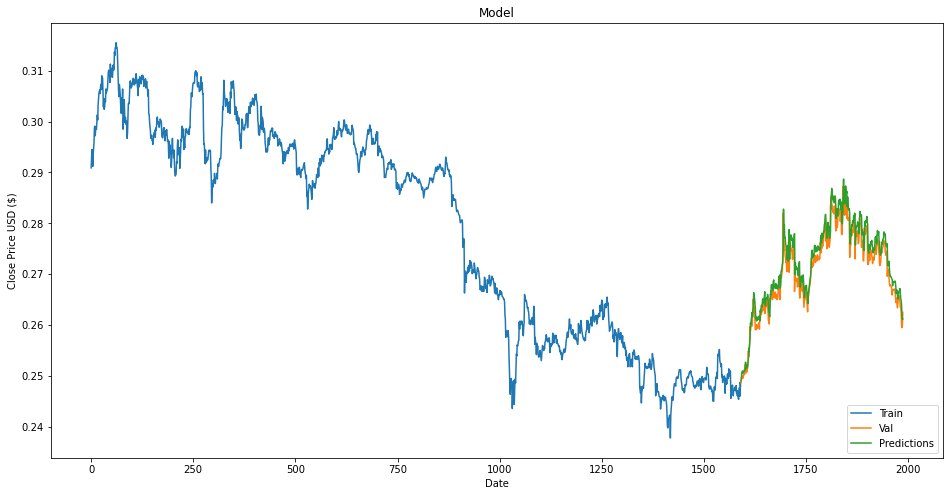

In [14]:
data = price_data_numeric
train = data[:training_data_len_price]
validation = pd.DataFrame()
validation['price'] = data[training_data_len_price:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

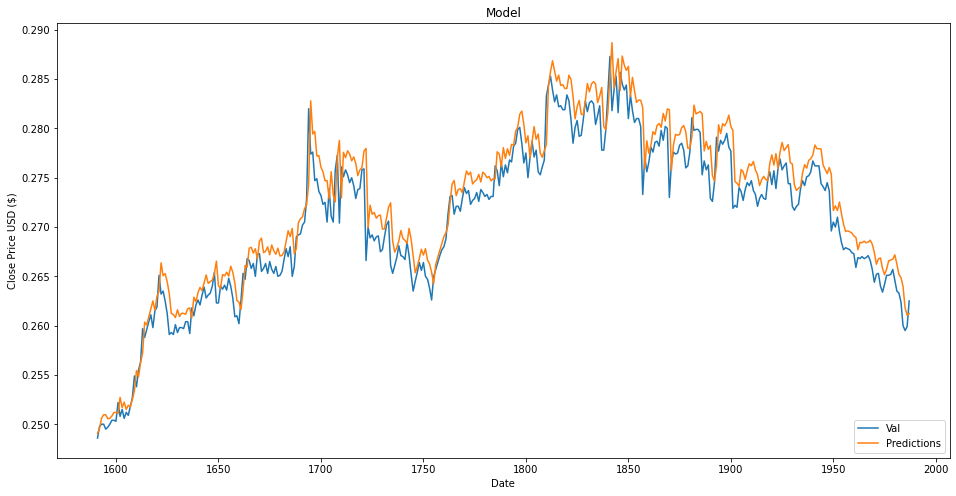

In [15]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(validation[['price', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()